# Statistiche schema mediato e schema merged

In [1]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
import re
from itertools import combinations
import shutil
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from itertools import combinations
import string

In [2]:
counter = 0
def make_path(file_name):
    global counter
    counter += 1
    return ".\\plot\\" + str(counter) + "-" + file_name

In [3]:
lilla = "#c8a2c8"
color_of_bar1 = "#c8a2c8"
color_of_bar2 = "#6495ED"
color_of_edge = "#000000"

In [4]:
# funzione di utilita per count_type_in_list(), serve a convertire una stringa in int o float
def maybeMakeNumber(s):
    if s is np.nan:
        return None
    if s is pd.NA:
        return None
    else:
        if not isinstance(s, float):
            try:
                return int(s)
            except:
                try:
                    return float(s)
                except:
                    return s
        else:
            return s

In [5]:
# conta il numero di int, float e str in una lista di stringhe
def count_type_in_list(l):
    info = {}
    converted = list(map(maybeMakeNumber, l))
    converted = [0 if isinstance(x, int) else x for x in converted]
    converted = [1 if isinstance(x, float) else x for x in converted]
    converted = [2 if isinstance(x, str) else x for x in converted]
    info["#int"] = converted.count(0)
    info["#float"] = converted.count(1)
    info["#str"] = converted.count(2)
    return info

In [6]:
# estrazione dati da un dataframe
def extract_data_from_df(df):
    info = {}
    info["#righe"] = df.shape[0]
    info["#colonne"] = df.shape[1]
    info["#celle"] = df.shape[0] * df.shape[1]
    info["#celle_nulle"] = df.isnull().sum().sum()
    info["#righe_con_celle_nulle"] = (df.isnull().sum(axis=1) != 0).sum()
    info["#colonne_con_celle_nulle"] = (df.isnull().sum(axis=0) != 0).sum()
    info["#celle_vuote"] = (df == '').sum().sum()
    info["#righe_con_celle_vuote"] = ((df == '').sum(axis=1) != 0).sum()
    info["#colonne_con_celle_vuote"] = ((df == '').sum(axis=0) != 0).sum()
    info["#celle_int"] = 0
    info["#celle_float"] = 0
    info["#celle_str"] = 0
    info["#colonne_int"] = 0
    info["#colonne_float"] = 0
    info["#colonne_str"] = 0
    for key in df:
        column = list(df[key])
        info_type = count_type_in_list(column)
        not_value_column = len(list(filter(lambda x: x is not np.nan and x is not pd.NA, column)))
        info["#celle_int"] += info_type["#int"]
        info["#celle_float"] += info_type["#float"]
        info["#celle_str"] += info_type["#str"]
        if not_value_column == info_type["#int"]:
            info["#colonne_int"] += 1
        elif not_value_column == info_type["#float"]:
            info["#colonne_float"] += 1
        elif not_value_column == info_type["#str"]:
            info["#colonne_str"] += 1
    info["#valori_distinti_per_colonna"] = {}
    info["#valori_nulli_per_colonna"] = {}
    for column in list(df.columns):
        info["#valori_distinti_per_colonna"][column] = df[column].nunique()
        info["#valori_nulli_per_colonna"][column] = df[column].isnull().sum(axis=0) 
    info["null_percentage"] = dict((df.isnull().mean() * 100).round(2))
    info["unique_percentage"] = dict(((df.nunique() / df.count()) * 100).round(2))    
    
    return info

In [7]:
dataset_path1 = "..\\idea_final_schema_parsed.csv"
dataset_path2 = "..\\dataset_FINALE.csv"

In [8]:
df1 = pd.read_csv(dataset_path1, low_memory=False)
df2 = pd.read_csv(dataset_path2, low_memory=False)

In [9]:
info1 = extract_data_from_df(df1)
distinct_value1 = info1.pop("#valori_distinti_per_colonna")
null_value1 = info1.pop("#valori_nulli_per_colonna")
null_percentage1 = info1.pop("null_percentage")
unique_percentage1 = info1.pop("unique_percentage")
df_info1 = pd.DataFrame(info1, index=["value"]).T
df_info1

,value
#righe,184587
#colonne,12
#celle,2215044
#celle_nulle,1312642
#righe_con_celle_nulle,184587
#colonne_con_celle_nulle,10
#celle_vuote,0
#righe_con_celle_vuote,0
#colonne_con_celle_vuote,0
#celle_int,186573


In [10]:
info2 = extract_data_from_df(df2)
distinct_value2 = info2.pop("#valori_distinti_per_colonna")
null_value2 = info2.pop("#valori_nulli_per_colonna")
null_percentage2 = info2.pop("null_percentage")
unique_percentage2 = info2.pop("unique_percentage")
df_info2 = pd.DataFrame(info2, index=["value"]).T
df_info2

,value
#righe,56532
#colonne,12
#celle,678384
#celle_nulle,380092
#righe_con_celle_nulle,56271
#colonne_con_celle_nulle,10
#celle_vuote,0
#righe_con_celle_vuote,0
#colonne_con_celle_vuote,0
#celle_int,57275


In [11]:
color_of_bar = "#c8a2c8"
color_of_edge = "#000000"
blu_fiordaliso = "#6495ED"

In [12]:
def two_bar_plot(keys, values1, values2, label1, label2, title, v_max, dim=(15, 5)):
    bar_width = 0.3
    plt.figure(figsize=dim)
    plt.title(title)
    file_name = "".join(title.lower()).replace(" ", "_")
    k1 = np.arange(len(values1))
    k2 = [x + bar_width for x in k1]
    p1 = plt.bar(k1, values1, width=bar_width, color=color_of_bar, edgecolor=color_of_edge, linewidth=1, align='center', label=label1)
    p2 = plt.bar(k2, values2, width=bar_width, color=blu_fiordaliso, edgecolor=color_of_edge, linewidth=1, align='center', label=label2)
    plt.bar_label(p1, label_type='edge')
    plt.bar_label(p2, label_type='edge')
    plt.xticks([r + (bar_width / 2) for r in range(len(values1))], keys, rotation=45, ha='right', rotation_mode='anchor')
    plt.margins(y=0.2)
    plt.grid(color=color_of_edge, linestyle='-', linewidth=0.5, axis="y")
    l = "{:,}".format(v_max)
    l = l.replace(',', '.')
    plt.yticks([v_max], [l])
    plt.legend()
    plt.savefig(make_path(file_name), bbox_inches='tight', transparent=True)
    plt.show()

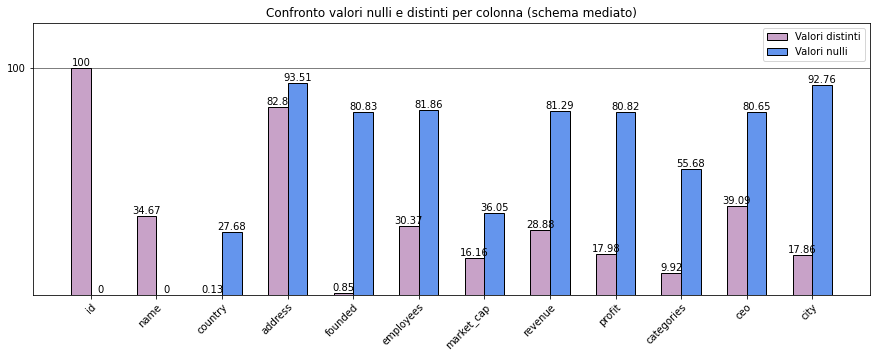

In [13]:
values1 = list(unique_percentage1.values())
values2 = list(null_percentage1.values())

label1 = "Valori distinti"
label2 = "Valori nulli"

keys = list(null_percentage1.keys())

title = "Confronto valori nulli e distinti per colonna (schema mediato)"

v_max = df_info1.loc["#righe"][0]

two_bar_plot(keys, values1, values2, label1, label2, title, 100)

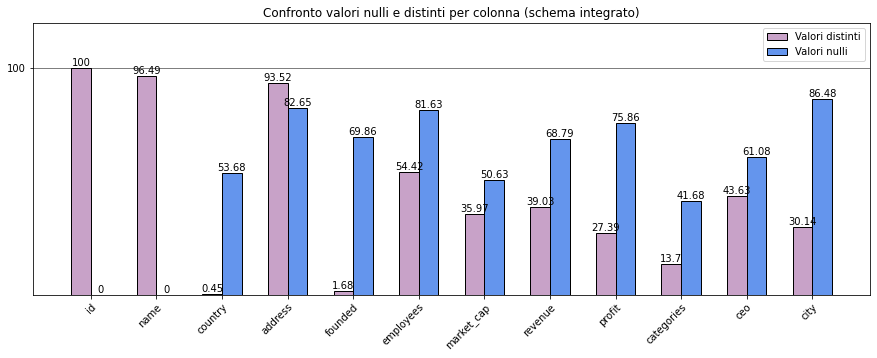

In [14]:
values1 = list(unique_percentage2.values())
values2 = list(null_percentage2.values())

label1 = "Valori distinti"
label2 = "Valori nulli"

keys = list(null_percentage2.keys())

title = "Confronto valori nulli e distinti per colonna (schema integrato)"

v_max = df_info2.loc["#righe"][0]
two_bar_plot(keys, values1, values2, label1, label2, title, 100)

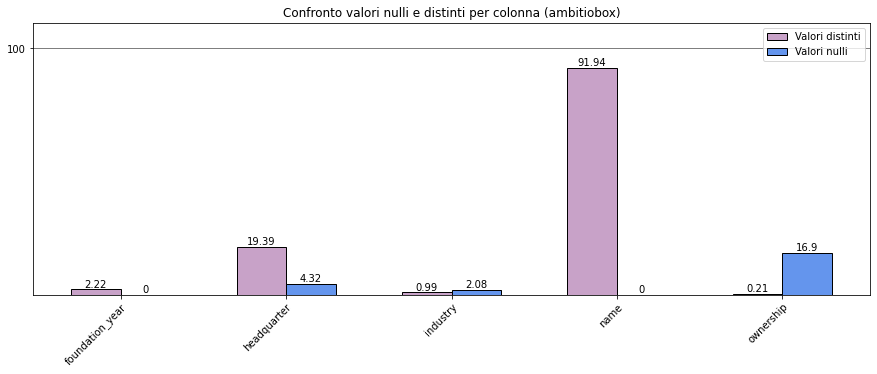

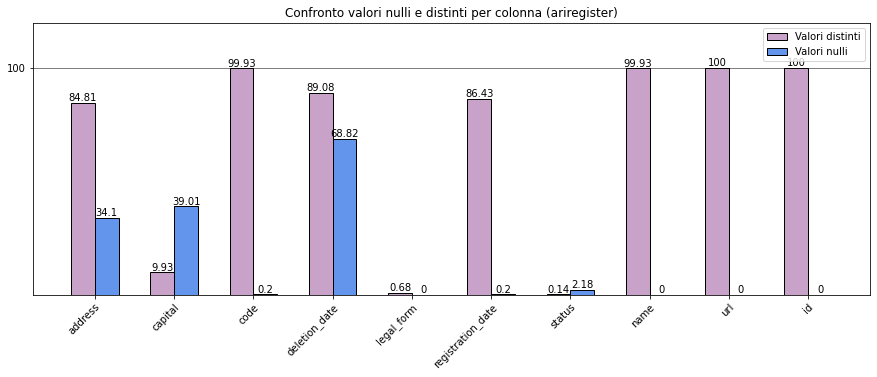

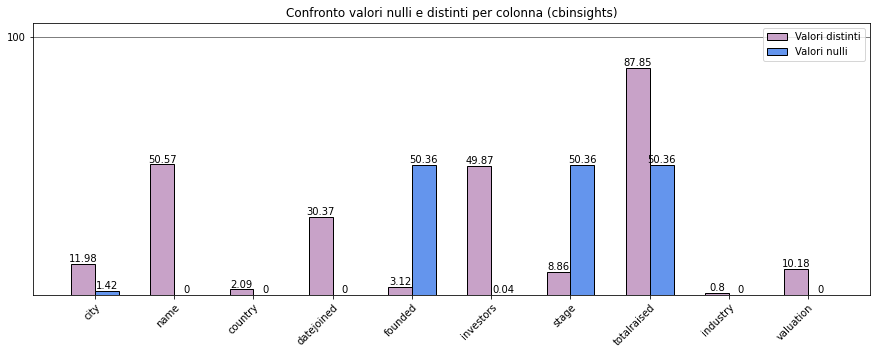

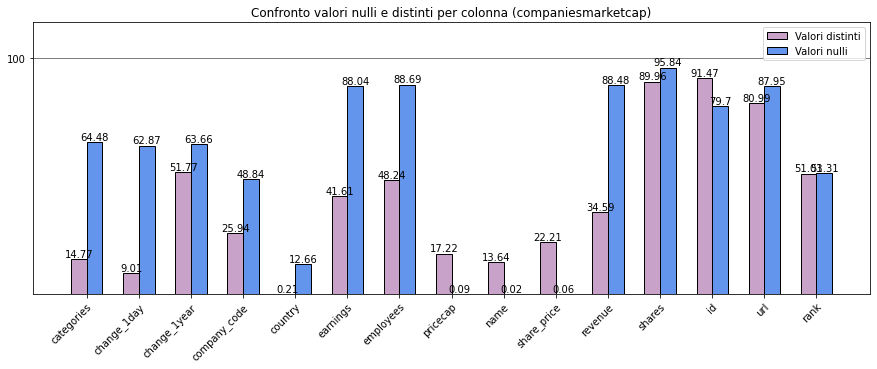

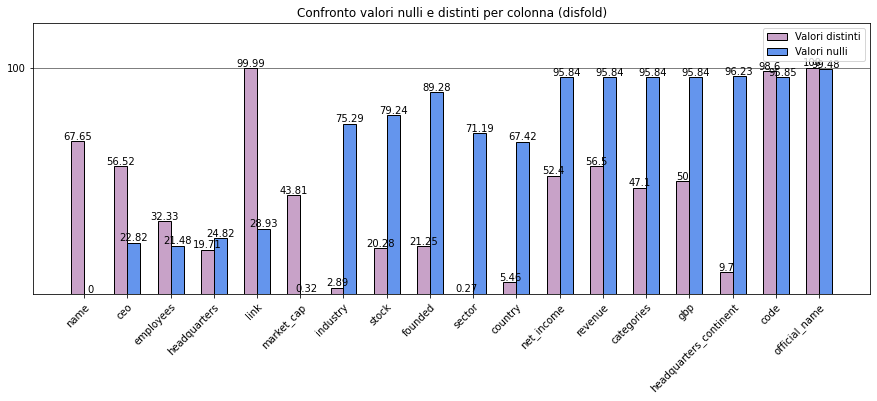

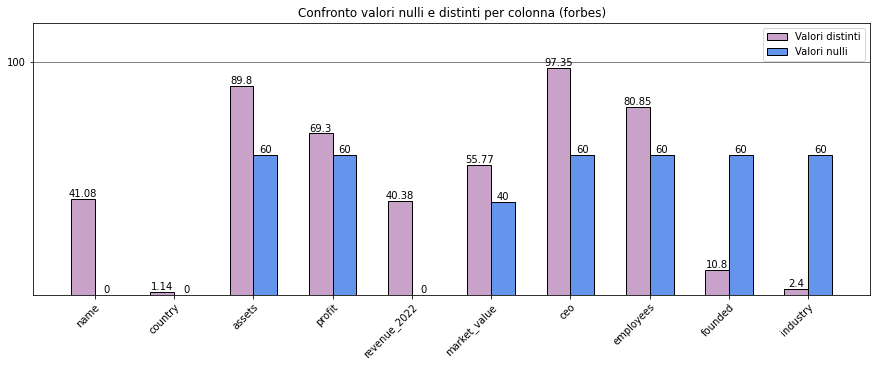

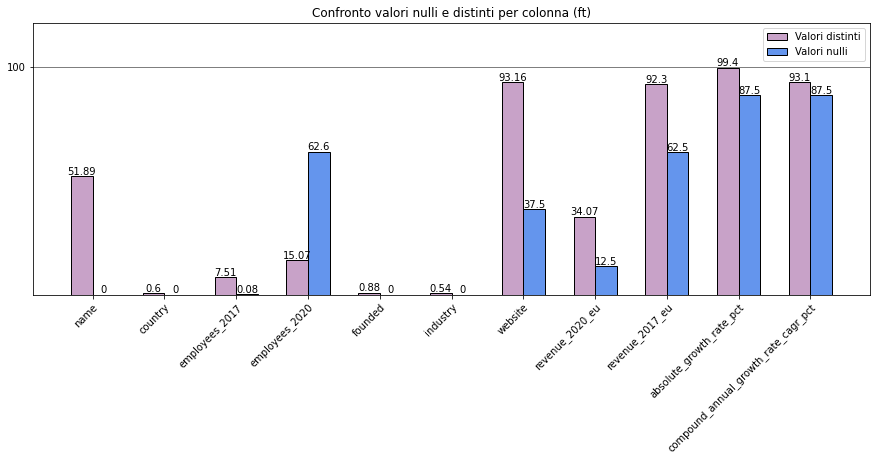

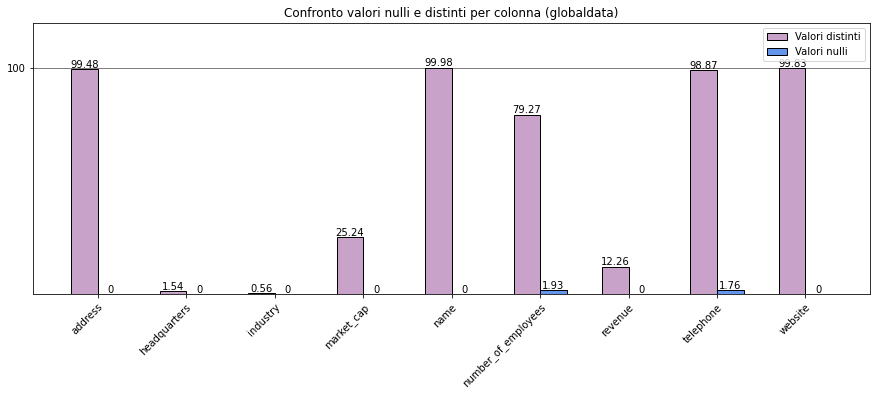

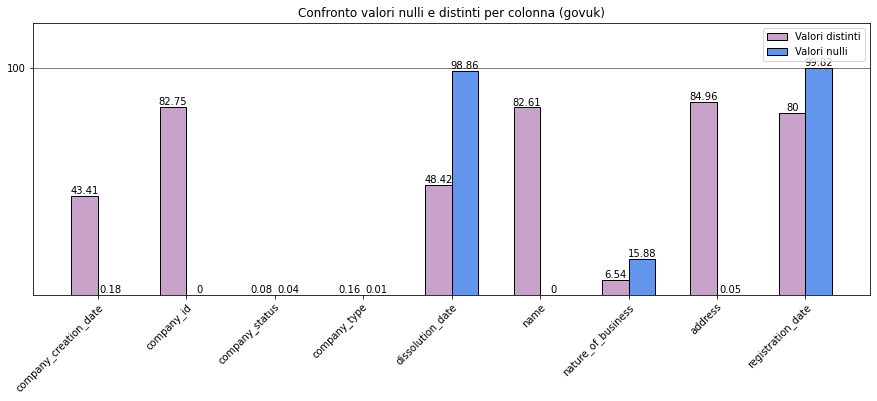

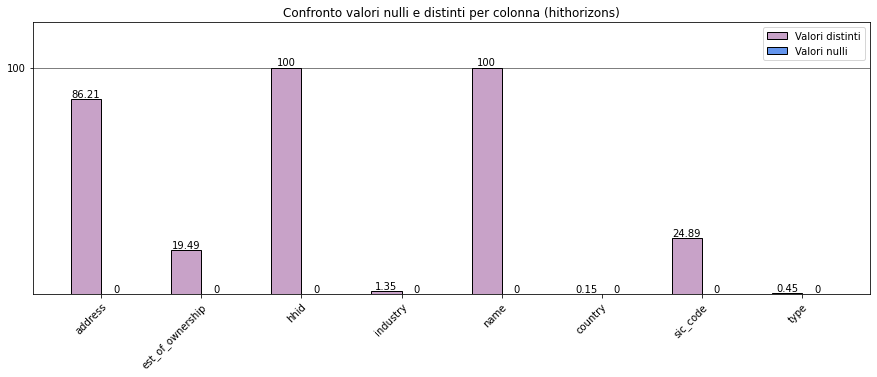

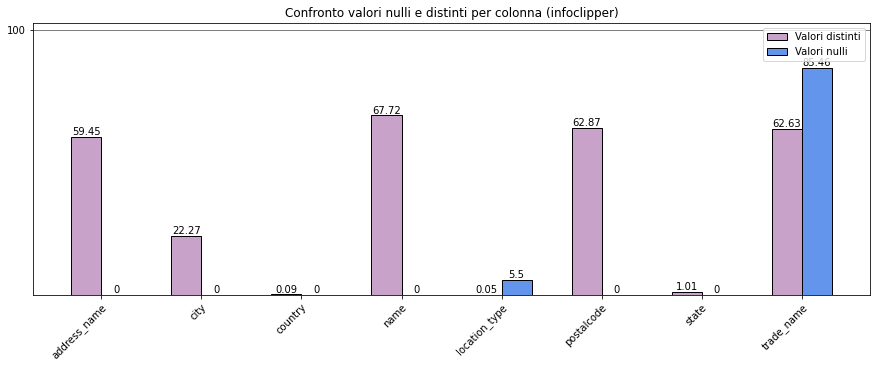

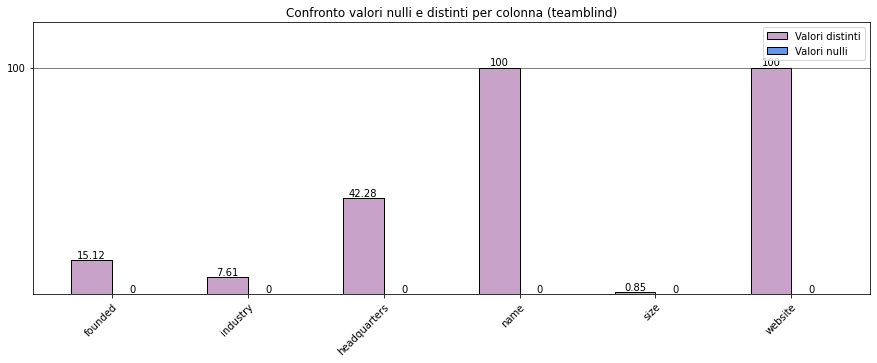

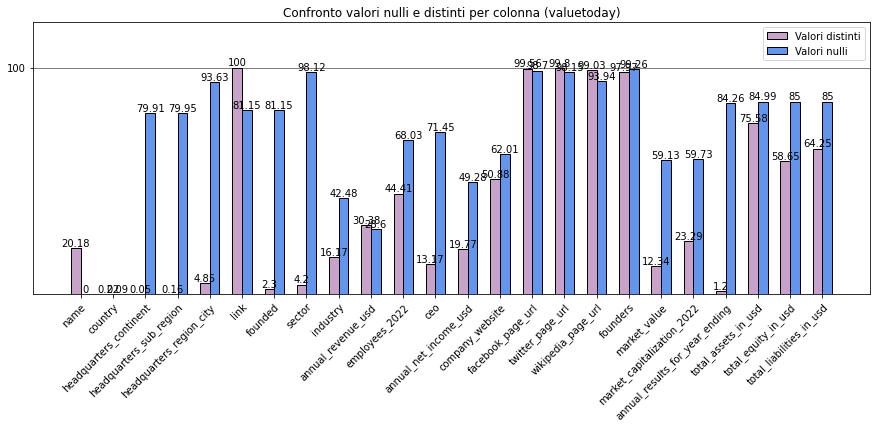

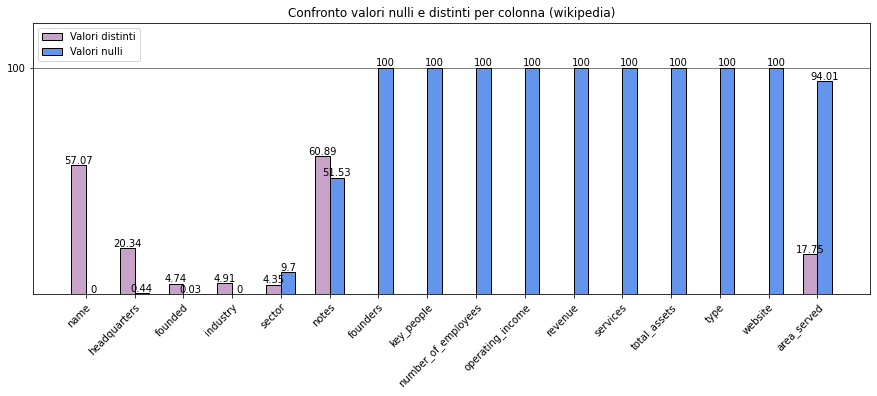

In [16]:
for filename in os.listdir("..\\..\\Dataset\\Schema\\"):
    file = os.path.join("..\\..\\Dataset\\Schema\\", filename)
    df = pd.read_csv(file, low_memory=False)
    info = extract_data_from_df(df)
    
    null_percentage = info.pop("null_percentage")
    unique_percentage = info.pop("unique_percentage")
    
    values1 = list(unique_percentage.values())
    values2 = list(null_percentage.values())

    label1 = "Valori distinti"
    label2 = "Valori nulli"

    keys = list(null_percentage.keys())

    title = "Confronto valori nulli e distinti per colonna (" + filename.split(".")[0] + ")"

    two_bar_plot(keys, values1, values2, label1, label2, title, 100)